# t-SNE
t-Distributed Stochastic Neighbor Embedding (t-SNE)

Buen vídeo básico de introducción al t-SNE
https://www.youtube.com/watch?v=NEaUSP4YerM

https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1



##  t-SNE

Para probar el método, vamos a crear un *dataset* formado por **tres grupos** de puntos generados con distintas localizaciones y varianzas.

In [1]:
import numpy as np
import pandas as pd

C1 = np.random.normal(loc=0., scale=1., size=(10,3))
I1 = np.ones(10, dtype=int)

#C2 = np.random.normal(loc=2., scale=0.1, size=(10,3))
C2 = np.random.normal(loc=5., scale=1., size=(10,3))
I2 = np.ones(10, dtype=int)*2

#C3 = np.random.normal(loc=5, scale=2, size=(10,3))
C3 = np.random.normal(loc=10, scale=1., size=(10,3))
I3 = np.ones(10, dtype=int)*3


df1 = pd.DataFrame(data=C1, columns=["x", "y", "z"])
df1I = pd.DataFrame(data=I1, columns=["class"])

df2 = pd.DataFrame(data=C2, columns=["x", "y", "z"])
df2I = pd.DataFrame(data=I2, columns=["class"])

df3 = pd.DataFrame(data=C3, columns=["x", "y", "z"])
df3I = pd.DataFrame(data=I3, columns=["class"])


result1 = pd.concat([df1, df1I], axis = 1, ignore_index=True, sort=False)
result2 = pd.concat([df2, df2I], axis = 1, ignore_index=True, sort=False)
result3 = pd.concat([df3, df3I], axis = 1, ignore_index=True, sort=False)

df = pd.concat([result1, result2, result3])
df.columns = ["x","y", "z","class"]
df = df.reset_index(drop=True)

Veamos los puntos de forma tabulada.


In [2]:
df

,x,y,z,class
0,0.166524,0.476437,-0.748905,1
1,-0.260890,-1.210117,1.111706,1
2,1.483352,0.980338,2.013879,1
3,-0.008549,0.257644,-1.536449,1
4,-1.467212,-0.370246,0.176544,1
5,-0.035987,0.426323,-1.165189,1
6,-1.098647,0.331815,1.964918,1
7,-0.272549,-0.040916,-0.370012,1
8,2.678083,0.933871,-0.728749,1
9,1.314680,0.550044,-1.232873,1


Visualicemos el conjunto de puntos tridimensional:

In [3]:
import plotly.express as px
import matplotlib.pyplot as plt

fig = px.scatter_3d(df, x="x", y="y", z="z", color="class")
fig.show()

<code>Q_points</code> será nuestro conjunto de puntos tridimensionales y <code>P_points</code> será nuestro conjunto de puntos bidimensionales con los que intentaremos visualizar el primer conjunto.

In [4]:
Q_points = df.values[:,0:3]  # Tomamos las coordenadas de los puntos, no la clase
P_points = np.random.uniform(0, 10, size=(30,2))  # Generamos puntos al azar

Si visualizamos el conjunto de puntos bidimensional, veremos que está totalmente desordenado (está generado al azar).

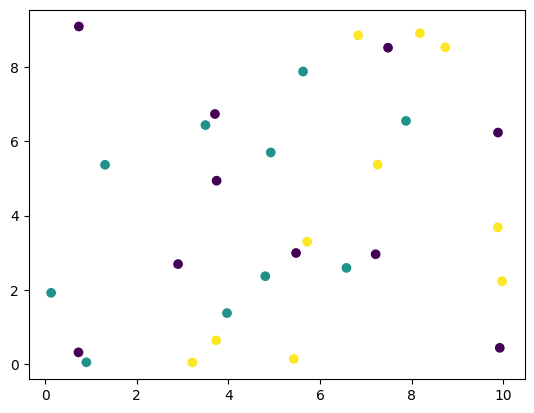

In [5]:
import matplotlib.pyplot as plt

P_index = np.concatenate((np.ones(10, dtype=int), np.ones(10, dtype=int)*2, np.ones(10, dtype=int)*3))
plt.scatter(P_points[:,0], P_points[:,1], c=P_index)

Antes de seguir vamos a echarle un vistazo a las matrices de distancia.

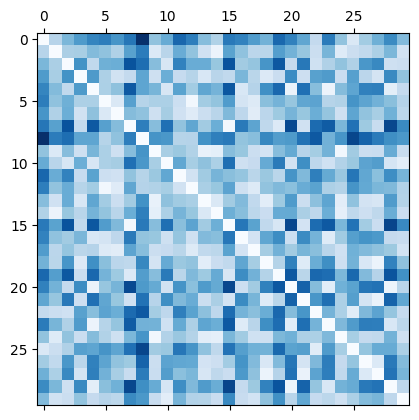

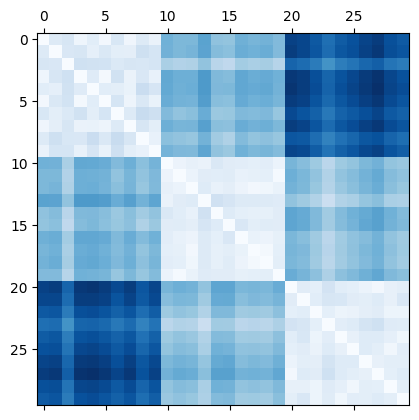

In [6]:
PM = np.zeros((30,30))
QM = np.zeros((30,30))

def distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

for i, p in enumerate(P_points):
    PM[i] = [distance(p, j) for j in P_points]
    
for i, q in enumerate(Q_points):
    QM[i] = [distance(q, j) for j in Q_points]
      
plt.matshow(PM, cmap=plt.cm.Blues)  # Representamos la matriz P
plt.matshow(QM, cmap=plt.cm.Blues)  # Representamos la matriz Q

Ahora nos hace falta definir una función para calcular la distancia entre puntos, otra para obtener la **función de distribución de probabilidad** y una última para calcular la divergencia de **Kullback-Leibler**.

In [7]:
import torch
import math

device = 'cuda' if torch.cuda.is_available() else 'cpu'

distT_torch = torch.distributions.studentT.StudentT(df=1, loc=0, scale=1)

def distance(p1, p2):
    return torch.sqrt(torch.sum((p1 - p2)**2) + 1e-6)
    
def pdf(x):
    return torch.exp(distT_torch.log_prob(x))

def KL(p, q):
    return torch.where(q > 0.1e-8, p * torch.log(p/q), torch.tensor([0.], dtype=torch.double, device=device)).sum()
    

Pasamos los puntos creados en Numpy a tensores de PyTorch <code>P</code> y <code>Q</code>. Los puntos <code>P</code> son los que tenemos que "mover", por eso requieren gradiente.

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

P = torch.tensor(P_points, requires_grad=True, dtype=torch.float, device=device)
Q = torch.tensor(Q_points, dtype=torch.float, device=device)

In [9]:
optimizer = torch.optim.RMSprop([P], lr=0.1)

epochs = 500

for k in range(epochs):
    
    PM = torch.tensor(np.zeros((len(P_points), len(P_points))), dtype=float, device=device)
    QM = torch.tensor(np.zeros((len(P_points), len(P_points))), dtype=float, device=device)
    
    for i, q_row in enumerate(Q):
        for j, q_column in enumerate(Q):
            QM[i, j] = distance(q_row, q_column)
    
    QD = pdf(QM)
    QD = torch.div(QD.t(), torch.sum(QD, dim=1)).t()
        
    for i, p in enumerate(P):
        for j, q in enumerate(P):
            PM[i, j] = distance(p, q)

    PD = pdf(PM)
    PD = torch.div(PD.t(), torch.sum(PD, dim=1)).t()
        
    loss = torch.tensor([0.], device=device)
    for pd, qd in zip(PD, QD):
        loss += KL(pd, qd)
    
    if k%10 == 0:
        print("Epoch:", k, "loss:", loss.item())
    

    loss.backward()   
    optimizer.step()    
    optimizer.zero_grad()

Epoch: 0 loss: 39.479583740234375
Epoch: 10 loss: 15.956965446472168
Epoch: 20 loss: 13.391416549682617
Epoch: 30 loss: 12.188273429870605
Epoch: 40 loss: 10.87851333618164
Epoch: 50 loss: 10.16821575164795
Epoch: 60 loss: 9.989543914794922
Epoch: 70 loss: 9.744491577148438
Epoch: 80 loss: 9.489737510681152
Epoch: 90 loss: 8.615865707397461
Epoch: 100 loss: 8.053683280944824
Epoch: 110 loss: 7.864839553833008
Epoch: 120 loss: 7.308864593505859
Epoch: 130 loss: 6.854788780212402
Epoch: 140 loss: 5.771241188049316
Epoch: 150 loss: 4.689131736755371
Epoch: 160 loss: 4.214322566986084
Epoch: 170 loss: 4.072487831115723
Epoch: 180 loss: 4.051445007324219
Epoch: 190 loss: 4.03515625
Epoch: 200 loss: 4.021659851074219
Epoch: 210 loss: 4.013899803161621
Epoch: 220 loss: 3.9985787868499756
Epoch: 230 loss: 3.986757516860962
Epoch: 240 loss: 3.977696180343628
Epoch: 250 loss: 3.969468593597412
Epoch: 260 loss: 3.959566116333008
Epoch: 270 loss: 3.9487476348876953
Epoch: 280 loss: 3.9359965324401

Visualizamos el resultado:

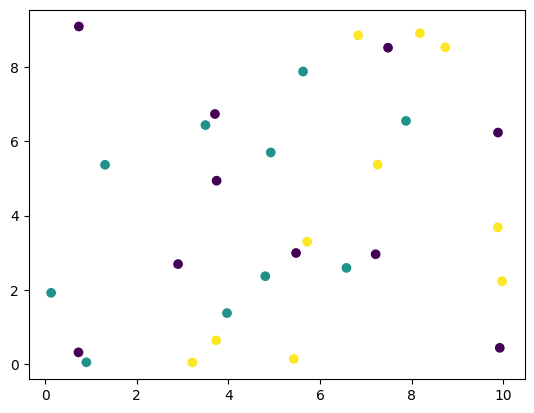

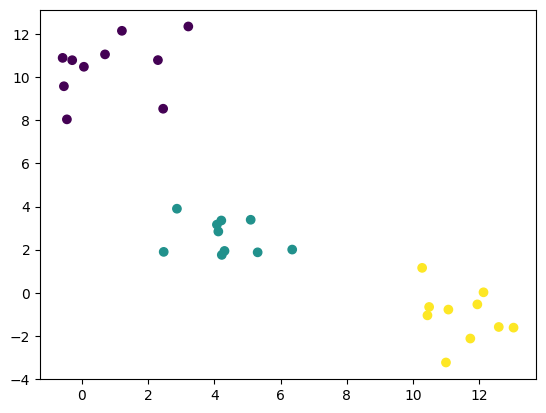

In [10]:
import matplotlib.pyplot as plt

final_points = P.cpu().detach().numpy()
P_index = np.concatenate((np.ones(10, dtype=int), np.ones(10, dtype=int)*2, np.ones(10, dtype=int)*3))


plt.scatter(P_points[:,0], P_points[:,1], c=P_index)
plt.show()

plt.scatter(final_points[:,0], final_points[:,1], c=P_index)

## Ejercicios

1. Crea el conjunto tridimensional anterior con tres clases con el mismo centro y dispersión. De esa forma, las clases serán no separables. Mira a ver qué ocurre con su visualización con t-SNE.

2. Calcula la visualización t-SNE usando el conjunto de datos IRIS.